In [1]:
import sys
import os
sys.path.append(os.path.abspath("../"))  # or "../../" depending on location
from setup import add_project_root
add_project_root()

In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from models.forward.FNO_models import FNO, FNO_noGrad
from models.forward.CNN_models import CNN
import time
import japanize_matplotlib
from notebooks.evaluate_functions import *

import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [3]:
# Load data
test_data = torch.load('../data/datasets/data/darcy_test_16.pt')
test_data_32 = torch.load("../data/datasets/data/darcy_test_32.pt")
x_test = test_data["x"].unsqueeze(1).float()
y_test = test_data["y"].unsqueeze(1).float()
x_test_32 = test_data_32["x"].unsqueeze(1).float()
y_test_32 = test_data_32["y"].unsqueeze(1).float()


/var/folders/k3/b1t1gjg12pg0ycfdgpm2k7g00000gn/T/ipykernel_73562/1095832022.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_data = torch.load('../data/datasets/data

In [4]:
# Load models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cnn = CNN(1, 1, 32).to(device)
cnn.load_state_dict(torch.load("../results/forward/checkpoints/best_darcy_cnn_model.pth", map_location=device))
cnn.eval()

fno = FNO(modes1=8, modes2=8, width=32).to(device)
fno.load_state_dict(torch.load("../results/forward/checkpoints/best_darcy_fno_model.pth", map_location=device))
fno.eval()


x_test = x_test.to(device)
y_test = y_test.to(device)

x_test_32 = x_test_32.to(device)
y_test_32 = y_test_32.to(device)


/var/folders/k3/b1t1gjg12pg0ycfdgpm2k7g00000gn/T/ipykernel_73562/2810942298.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn.load_state_dict(torch.load("../results/fo

In [5]:
# inference test data(16 x 16)

inference_times = {}
metrics = {}
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# 推論時間の評価に興味がない場合は、warmupとrepeatを0に設定してください。
warmup = 10
repeat = 1000

with torch.no_grad():

    # CNN
    pred_cnn = cnn(x_test).cpu().numpy()
    inference_times["CNN"] = measure_inference_time(cnn, x_test, warmup=warmup, repeat=repeat)
    metrics["CNN"] = evaluate(pred_cnn, y_test.cpu().numpy())
    print(f"Number of parameters in CNN: {count_params(cnn)}")



    # FNO
    x_test_fno = x_test.permute(0, 2, 3, 1)  # (B, H, W, 1)
    pred_fno = fno(x_test_fno).cpu().numpy()
    inference_times["FNO"] = measure_inference_time(fno, x_test_fno,warmup=warmup,repeat=repeat)
    metrics["FNO"] = evaluate(pred_fno, y_test.cpu().numpy())
    print(f"Number of parameters in FNO: {count_params(fno)}")
    
    y_true = y_test.cpu().numpy()
    

    


print_inference_and_metrics(inference_times,metrics)




Number of parameters in CNN: 416481
Number of parameters in FNO: 204257
【評価結果】

【推論時間（ms）】
CNN            : 25.79 ms
FNO            : 22.73 ms

【評価指標】
Model                    MSE       PSNR       SSIM       HF_MSE
-----------------------------------------------------------------
CNN               3.0258e-03      25.19     0.9792   1.7452e-01
FNO               1.8002e-01      20.96     0.9432   4.5290e+01


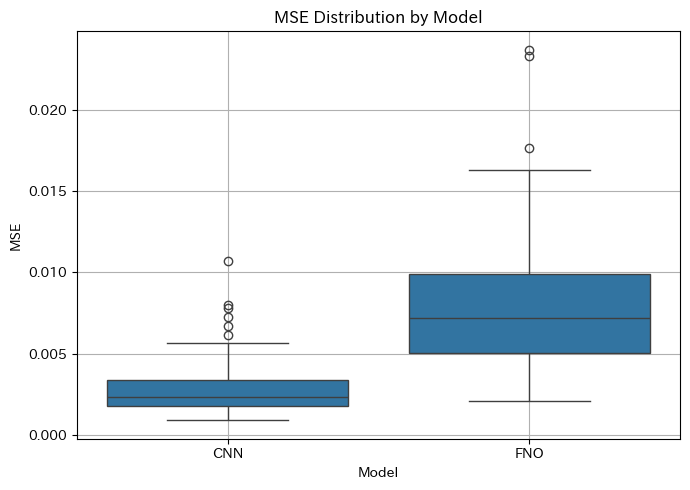

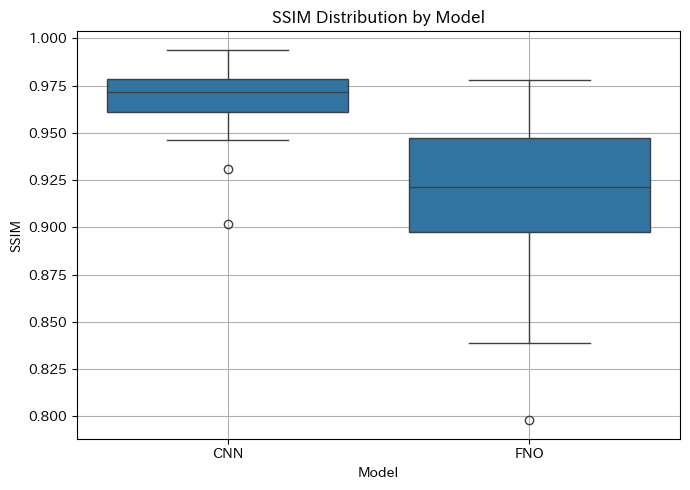

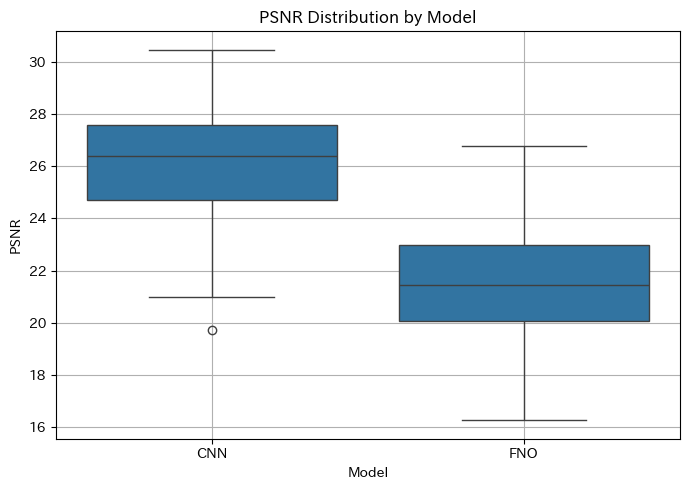

In [6]:
# evaluate per sample
scores_cnn = evaluate_all(pred_cnn, y_test)
scores_fno = evaluate_all(pred_fno, y_test)

# --- スコア抽出 ---
mse_cnn = [s["MSE"] for s in scores_cnn]
mse_fno = [s["MSE"] for s in scores_fno]
ssim_cnn = [s["SSIM"] for s in scores_cnn]
ssim_fno = [s["SSIM"] for s in scores_fno]
psnr_cnn = [s["PSNR"] for s in scores_cnn]
psnr_fno = [s["PSNR"] for s in scores_fno]

boxplot_metric_comparison({"CNN": mse_cnn, "FNO": mse_fno}, metric_name="MSE")
boxplot_metric_comparison({"CNN": ssim_cnn, "FNO": ssim_fno}, metric_name="SSIM")
boxplot_metric_comparison({"CNN": psnr_cnn, "FNO": psnr_fno}, metric_name="PSNR")


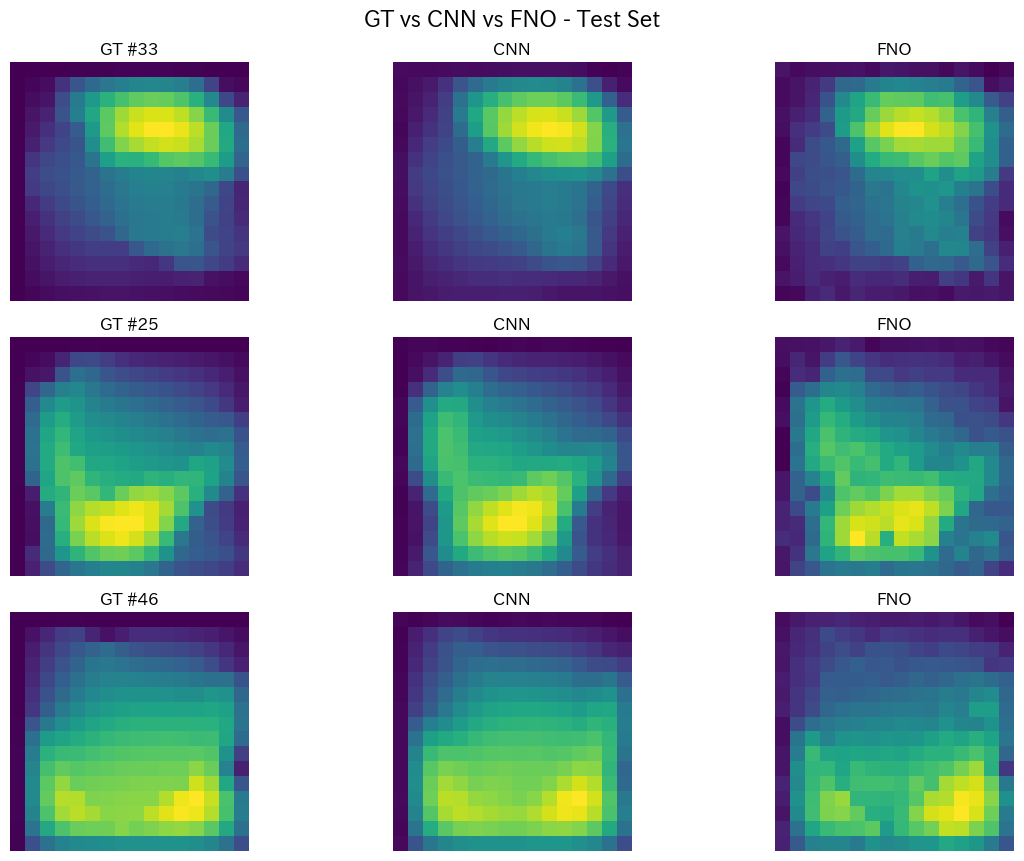

In [7]:
# visualize prediction samples
gt_images = y_true.squeeze(1)                    # [B, 1, H, W] → [B, H, W]  
cnn_images = pred_cnn.squeeze(1)              # [B, 1, H, W]
fno_images = pred_fno.squeeze(-1)                # [B, H, W, 1]

preds = [cnn_images,  fno_images]
labels = ["CNN", "FNO"]
plot_gt_pred_comparison(gt_images,preds,labels, num_samples=3, title="GT vs CNN vs FNO - Test Set")

/Users/yamashitanatsuki/Documents/Python/neural_operator_comparison/notebooks/evaluate_functions.py:248: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.91, 0.94])


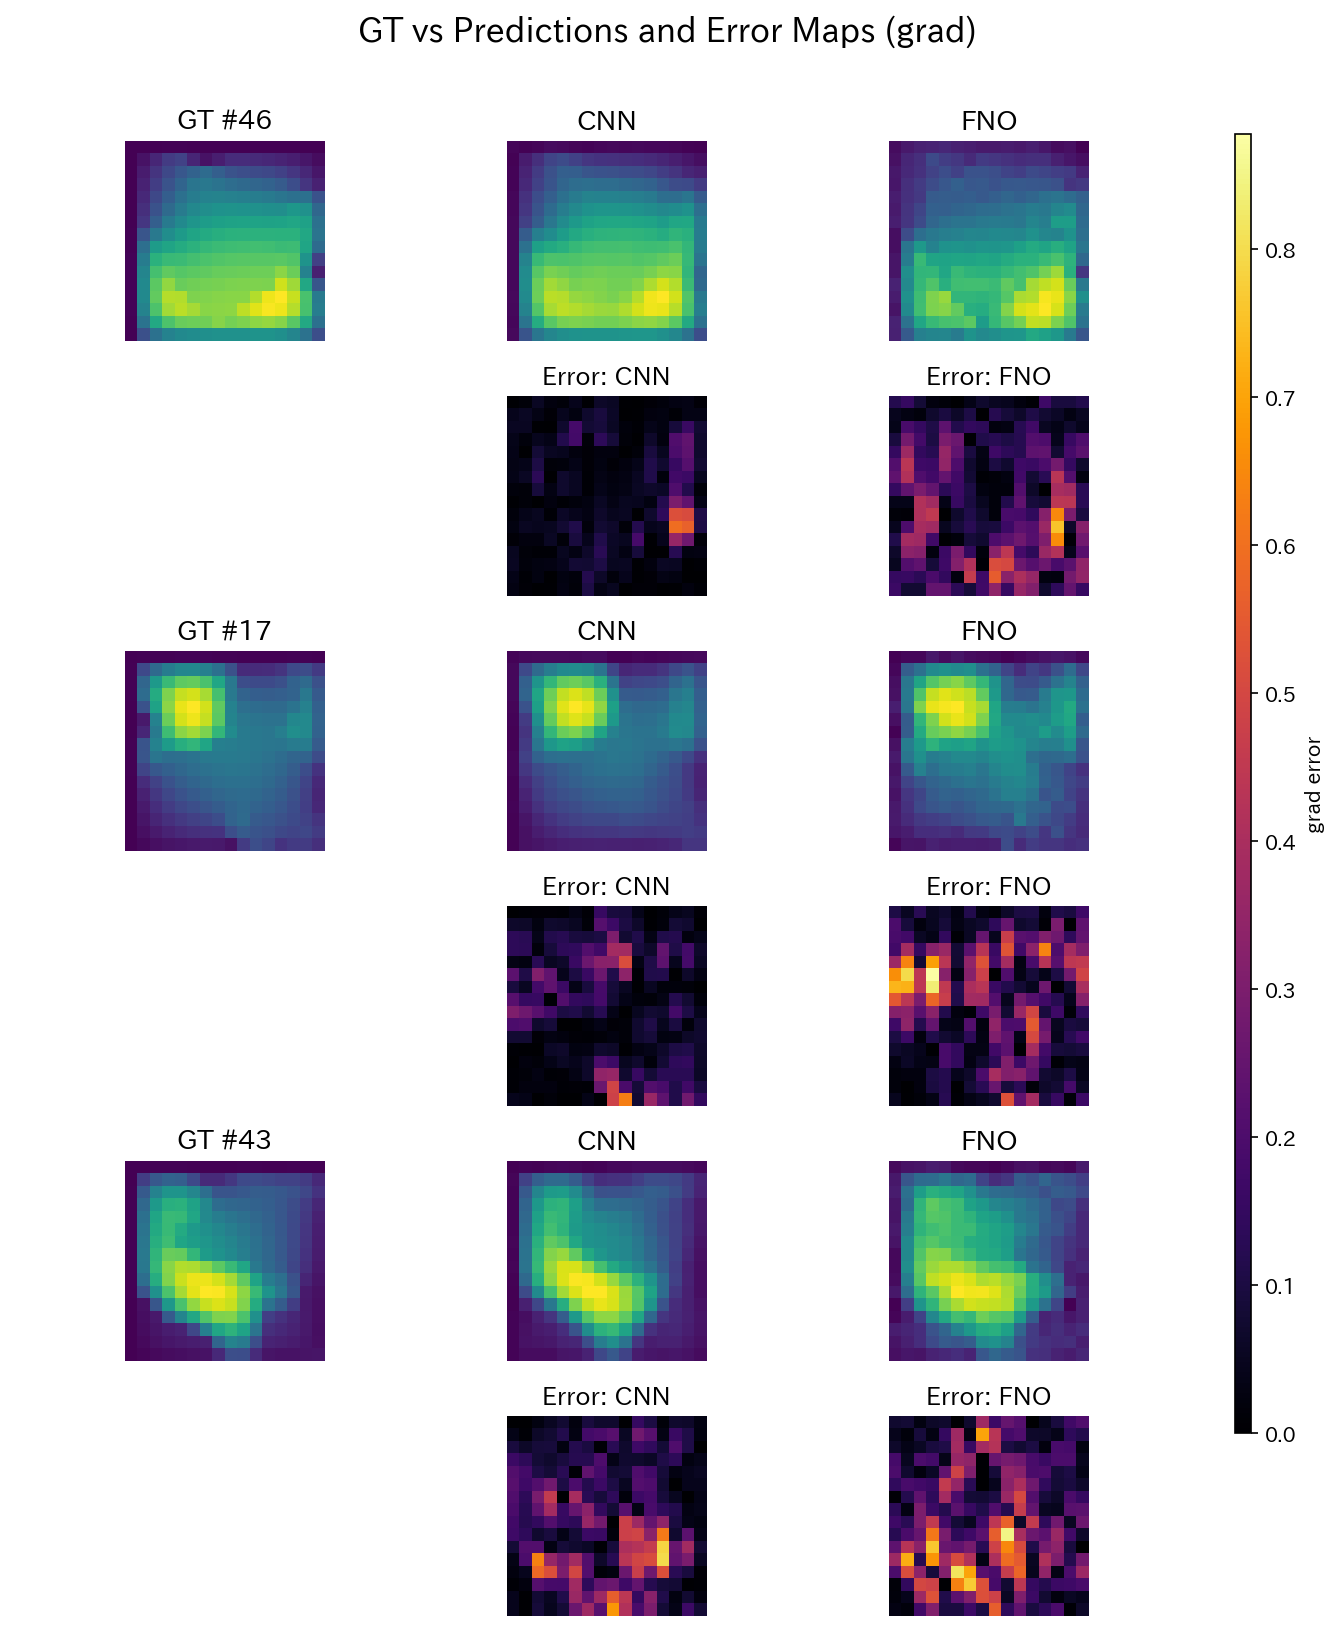

In [8]:
# visualize prediction error
error_type = "grad" # error_type = "abs", "square", "grad","ssim"から選択
plot_comparison_with_error_maps(gt_images,preds,labels, num_samples=3,error_type=error_type)

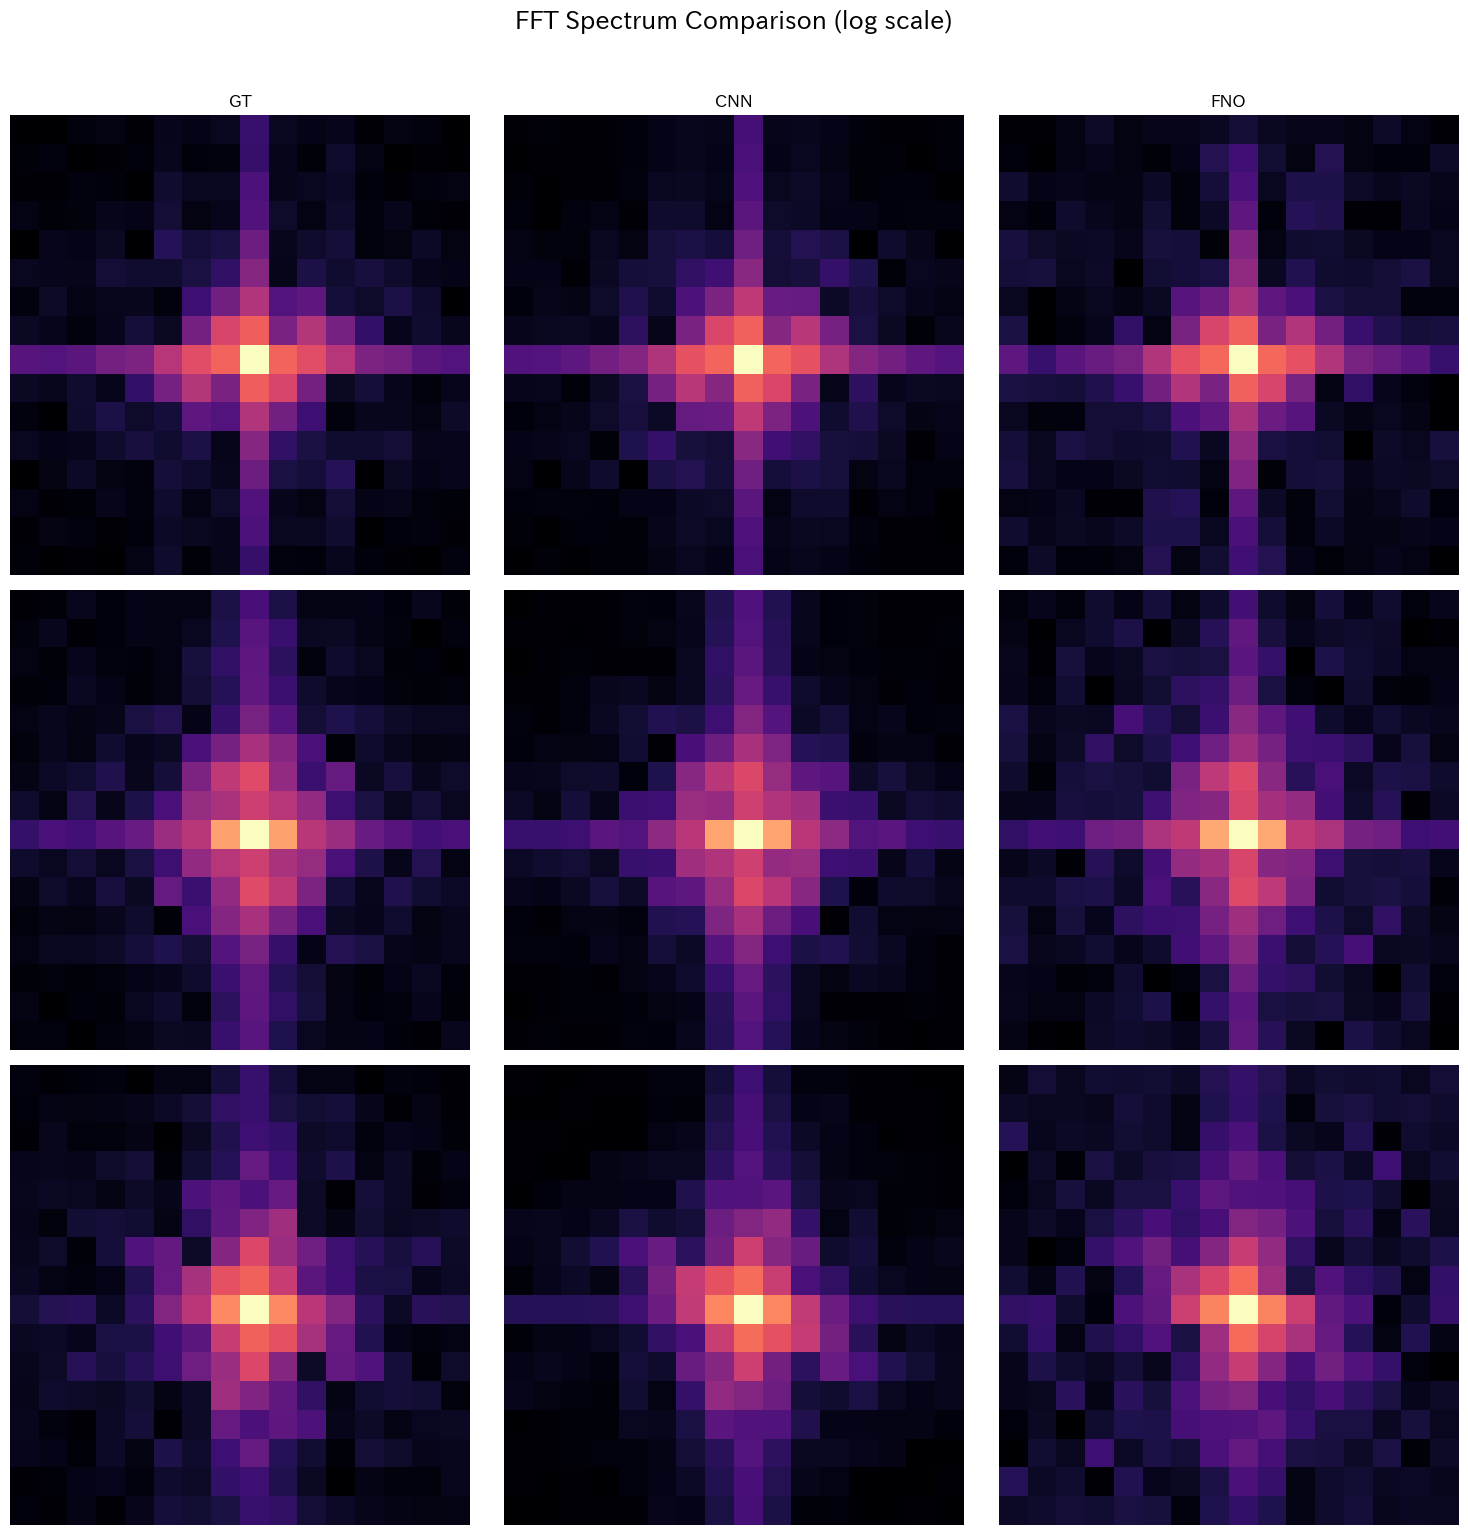

In [9]:
# visualize spectrum
compare_fft_spectra(
    gt_images=gt_images,
    pred_images_list=preds,
    labels_list=labels,
    num_samples=3
)

In [10]:
# inference test data(32x32)
inference_times_32 = {}
metrics_32 = {}

with torch.no_grad():
    # CNN
    pred_cnn_32 = cnn(x_test_32).cpu().numpy()
    inference_times_32["CNN"] = measure_inference_time(cnn, x_test_32, warmup=10, repeat=1000)
    metrics_32["CNN"] = evaluate(pred_cnn_32, y_test_32.cpu().numpy())


    # FNO
    x_test_fno_32 = x_test_32.permute(0, 2, 3, 1)  # (B, H, W, 1)
    pred_fno_32 = fno(x_test_fno_32).cpu().numpy()
    inference_times_32["FNO"] = measure_inference_time(fno, x_test_fno_32,warmup=10,repeat=1000)
    metrics_32["FNO"] = evaluate(pred_fno_32, y_test_32.cpu().numpy())


    y_true_32 = y_test_32.cpu().numpy()

print_inference_and_metrics(inference_times_32,metrics_32)


【評価結果】

【推論時間（ms）】
CNN            : 88.17 ms
FNO            : 61.82 ms

【評価指標】
Model                    MSE       PSNR       SSIM       HF_MSE
-----------------------------------------------------------------
CNN               2.2589e-01       6.46     0.6209   1.0564e+00
FNO               1.7411e-01      19.47     0.9122   1.7880e+02


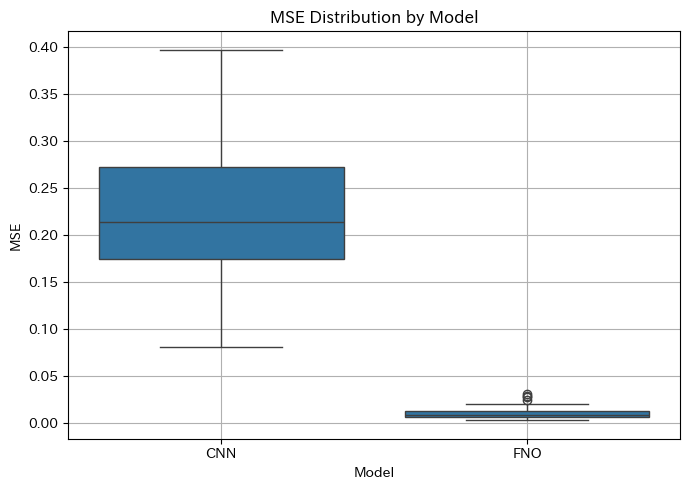

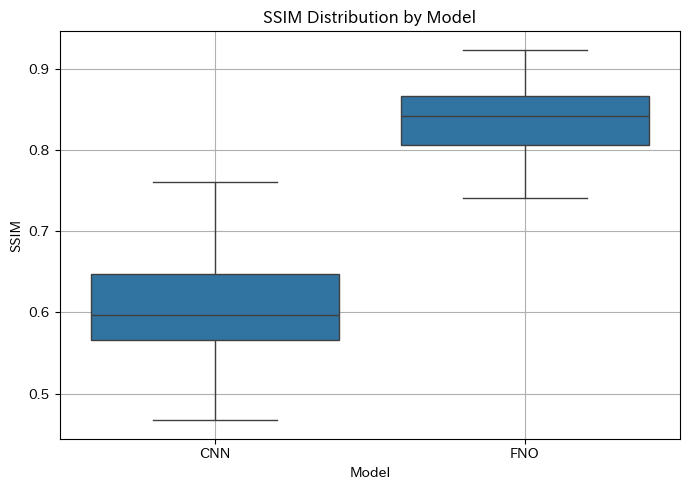

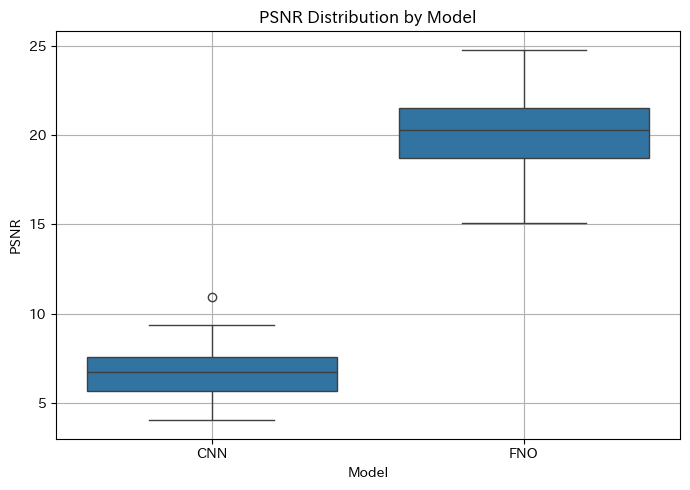

In [12]:
# evaluate per sample
scores_cnn_32 = evaluate_all(pred_cnn_32, y_test_32)
scores_fno_32 = evaluate_all(pred_fno_32, y_test_32)

mse_cnn_32 = [s["MSE"] for s in scores_cnn_32]
mse_fno_32 = [s["MSE"] for s in scores_fno_32]
ssim_cnn_32 = [s["SSIM"] for s in scores_cnn_32]
ssim_fno_32 = [s["SSIM"] for s in scores_fno_32]
psnr_cnn_32 = [s["PSNR"] for s in scores_cnn_32]
psnr_fno_32 = [s["PSNR"] for s in scores_fno_32]

boxplot_metric_comparison({"CNN": mse_cnn_32, "FNO": mse_fno_32}, metric_name="MSE")
boxplot_metric_comparison({"CNN": ssim_cnn_32, "FNO": ssim_fno_32}, metric_name="SSIM")
boxplot_metric_comparison({"CNN": psnr_cnn_32, "FNO": psnr_fno_32}, metric_name="PSNR")



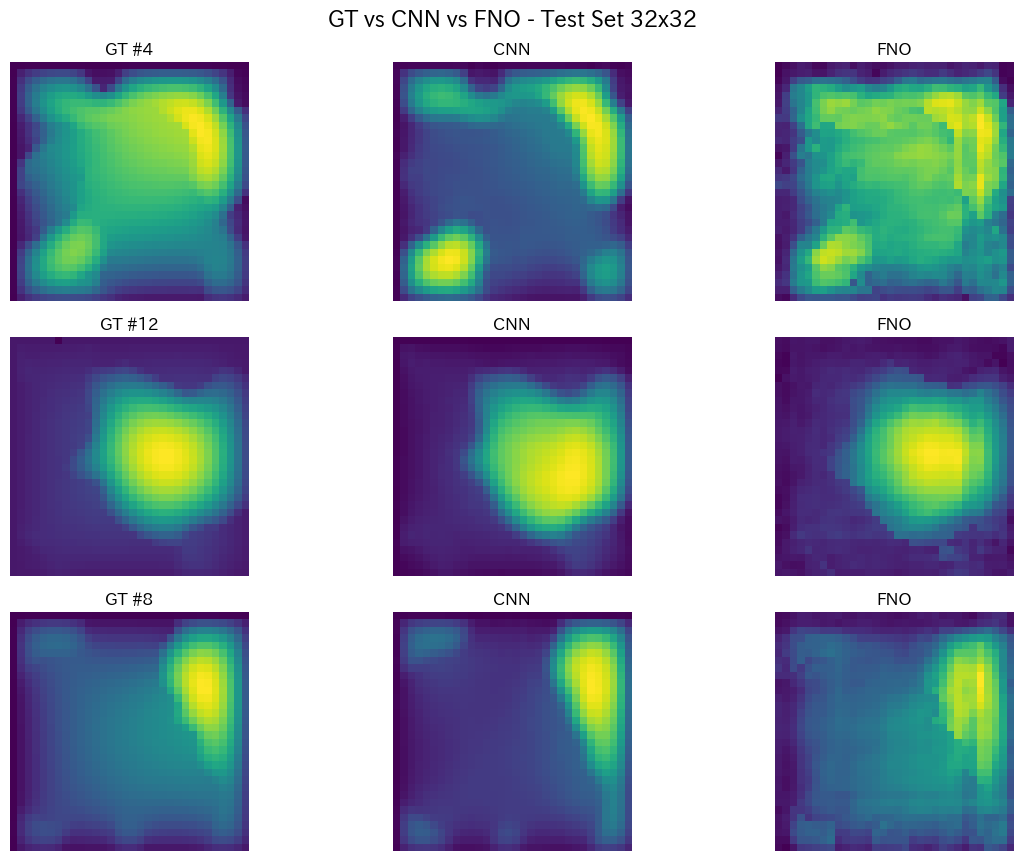

In [13]:
# visualize prediction samples
gt_images_32 = y_true_32.squeeze(1)                    # [B, 1, H, W] → [B, H, W]
cnn_images_32 = pred_cnn_32.squeeze(1)                 # [B, 1, H, W]
fno_images_32 = pred_fno_32.squeeze(-1)                # [B, H, W, 1]

preds_32 = [cnn_images_32, fno_images_32]
labels_32 = ["CNN", "FNO"]


plot_gt_pred_comparison(gt_images_32,preds_32,labels_32,num_samples=3, title="GT vs CNN vs FNO - Test Set 32x32")


/Users/yamashitanatsuki/Documents/Python/neural_operator_comparison/notebooks/evaluate_functions.py:248: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.91, 0.94])


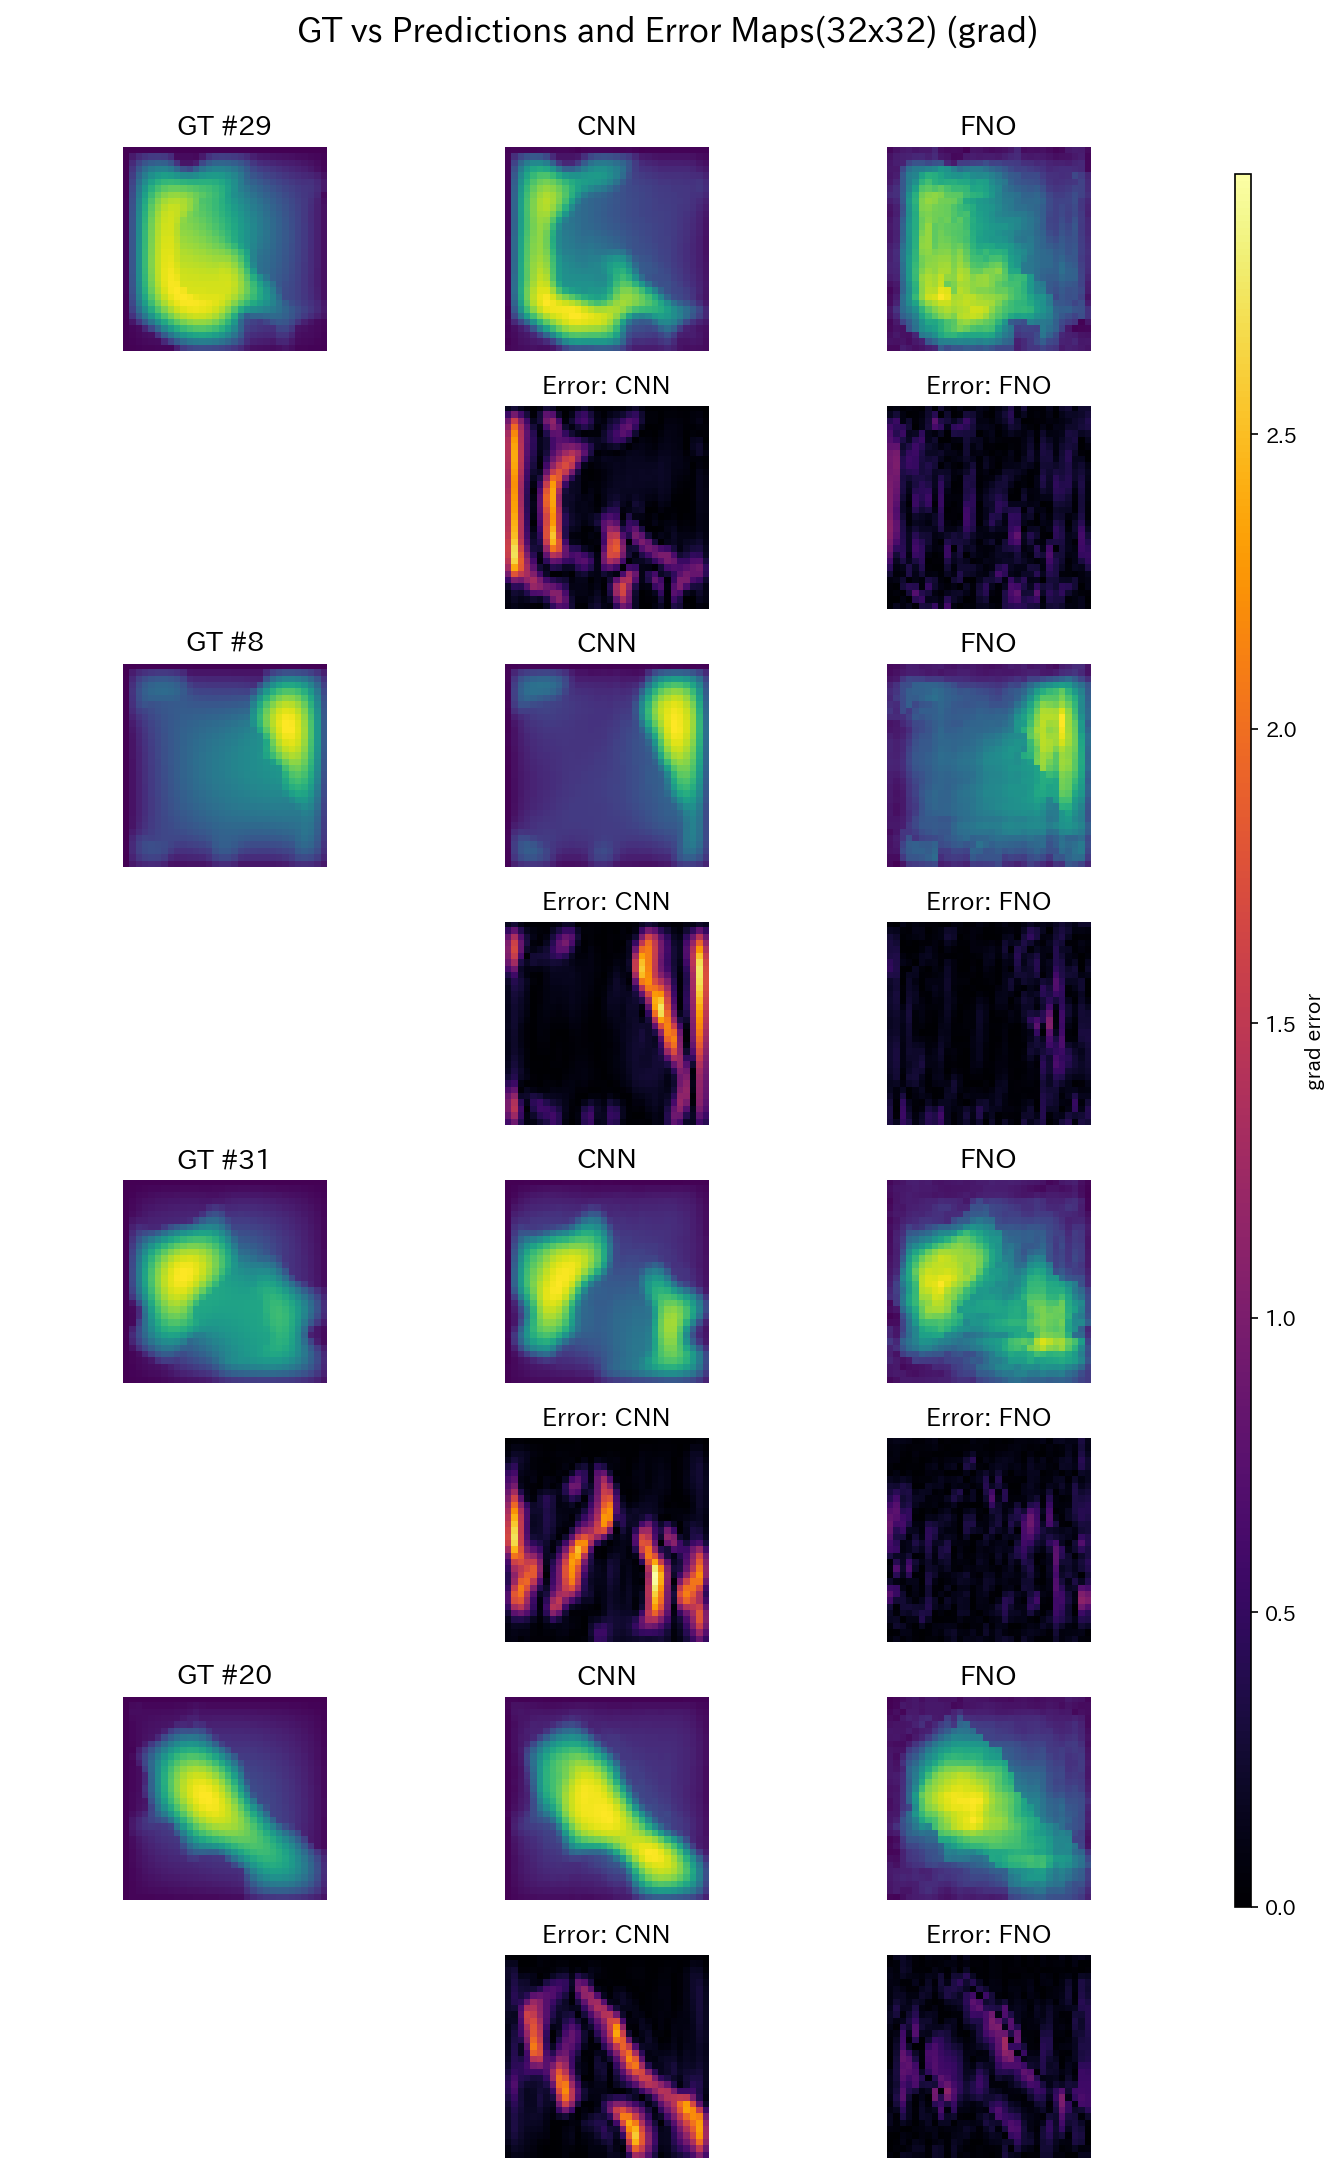

In [14]:
# visualize prediction error
error_type = "grad"  # error_type = "abs", "square", "grad","ssim"から選択
plot_comparison_with_error_maps(gt_images_32,preds_32,labels_32,num_samples=4, title = f"GT vs Predictions and Error Maps(32x32) ({error_type})",error_type=error_type)

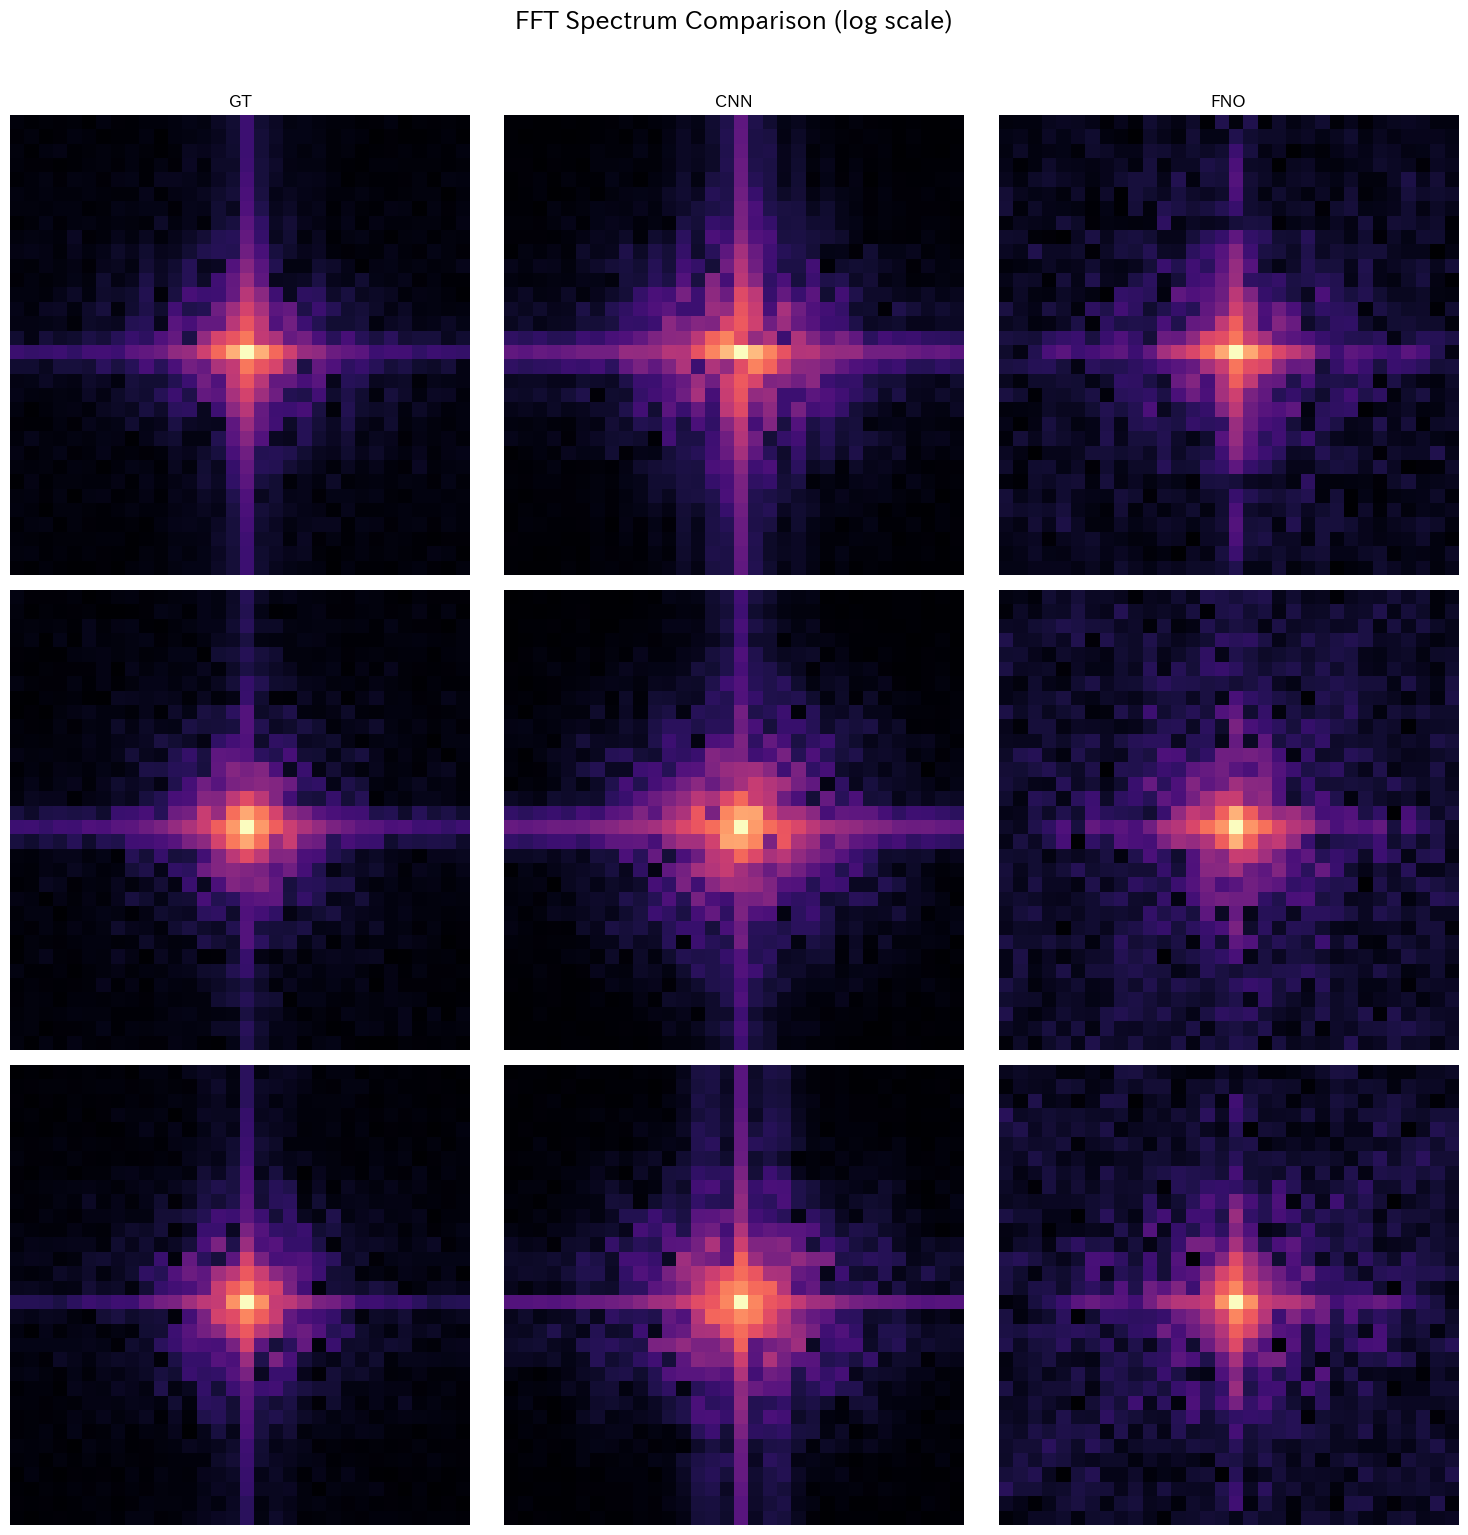

In [15]:
# visualize spectrum
compare_fft_spectra(
    gt_images=gt_images_32,
    pred_images_list=preds_32,
    labels_list=labels_32,
    num_samples=3
)